# 쇼핑몰 리뷰 평점 분류 경진대회

## 데이터 불러오기

In [34]:
import numpy as np
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')

In [5]:
os.getcwd()

'C:\\Users\\Jaesu\\github_desktop\\Dacon-Basic\\쇼핑몰리뷰-평점-분류\\쇼핑몰리뷰-평정-분류-모델링'

In [6]:
os.chdir('C:\\Users\\Jaesu\\github_desktop\\Dacon-Basic\\쇼핑몰리뷰-평점-분류')

In [3]:
SEED = 22

In [20]:
sns.set_theme(style='white')

In [21]:
def ACCURACY(true, pred):   
    score = np.mean(true == pred)
    return score

In [7]:
df = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
submission = pd.read_csv('./Data/sample_submission.csv')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       25000 non-null  int64 
 1   reviews  25000 non-null  object
 2   target   25000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 586.1+ KB


`-` 결측치는 없으며 데이터는 리뷰와 평점으로 구성되어 있다

## EDA

<AxesSubplot:xlabel='target', ylabel='count'>

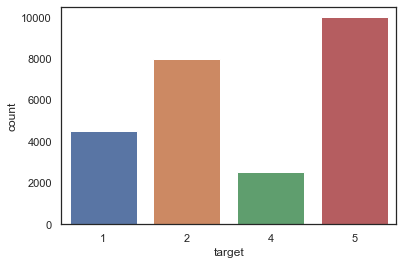

In [23]:
sns.countplot(data=df, x='target')

<AxesSubplot:>

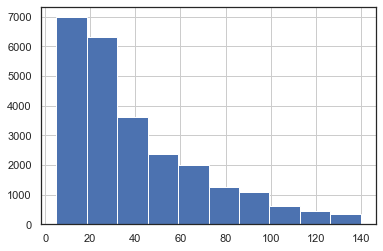

In [22]:
df['reviews'].str.len().hist()

`-` 띄어쓰기를 포함한 텍스트 길이는 오른쪽으로 꼬리가 긴 분포를 띄고 있다

`-` 길이가 0인 리뷰는 없다

`-` 최소 길이는 5이며 최대 길이는 140이다

<AxesSubplot:xlabel='target', ylabel='reviews'>

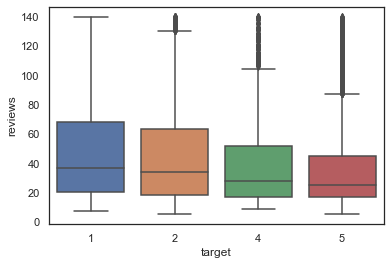

In [26]:
sns.boxplot(data=df, x='target', y=df['reviews'].str.len())

`-` 리뷰의 길이가 길수록 평점이 낮은 경향이 있다

## 데이터 전처리

In [450]:
def clean_text(texts): 
    corpus = [] 
    for text in texts: 
        review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"\n\]\[\>]', '', text) ## @%*=()/+ 와 같은 문장부호 제거
        review = re.sub(r'\d+','', review) ## 숫자 제거
        review = review.lower() ## 소문자 변환
        review = re.sub(r'\s+', ' ', review) ## extra space 제거
        review = re.sub(r'<[^>]+>', '', review) ## Html tags 제거
        review = re.sub(r"^\s+", '', review) ## space from start 제거
        review = re.sub(r'\s+$', '', review) ## space from the end 제거
        review = re.sub(r'_', ' ', review) ## space from the end 제거
        corpus.append(review) 

    return corpus

In [451]:
df['clean_reviews'] = clean_text(df['reviews'])
test['clean_reviews'] = clean_text(test['reviews'])

<AxesSubplot:>

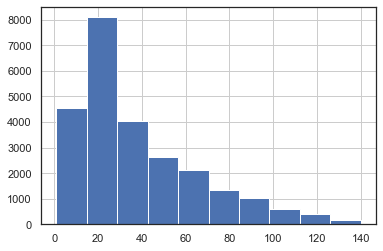

In [452]:
df['clean_reviews'].str.len().hist()

## 모델링

In [265]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.naive_bayes import BernoulliNB, ComplementNB
from sklearn.linear_model import SGDClassifier, LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

`-` `CountVectorizer`는 성능이 별로다

`-` 전처리를 안했을 때 성능이 더 좋다

`-` `TfidfVectorizer`의 `analyzer`로 `word`보다 `char`를 사용했을 때 성능이 더 좋다

`-` `analyzer=char, ngram_range=(1, 4)`일 때 성능이 가장 우수하다

`-` `max_features` 옵션을 바꿔보자

### TfidfVectorizer, word

In [138]:
tfidf1 = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), sublinear_tf=True)
tfidf2 = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), sublinear_tf=True)
tfidf3 = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), sublinear_tf=True)

In [163]:
%%time
train_tfidf1 = tfidf1.transform(df['reviews'])
test_tfidf1 = tfidf1.transform(test['reviews'])

train_tfidf2 = tfidf2.transform(df['reviews'])
test_tfidf2 = tfidf2.transform(test['reviews'])

train_tfidf3 = tfidf3.transform(df['reviews'])
test_tfidf3 = tfidf3.transform(test['reviews'])

Wall time: 3.23 s


In [164]:
target = df['target']

In [165]:
k = 10
skfold = StratifiedKFold(k, shuffle=True, random_state=SEED)

- 텍스트 전처리에 따른 모델별 정확도

In [166]:
SGD = SGDClassifier(loss='hinge', random_state=SEED)
LSVC = LinearSVC(random_state=SEED, C=0.1)
CNB = ComplementNB(alpha=2.5)

`-` `ngram_range = (1, 1)`

In [167]:
%%time
scores_LSVC = cross_validate(LSVC, train_tfidf1, target, scoring=('accuracy'), cv=skfold)
scores_SGD = cross_validate(SGD, train_tfidf1, target, scoring=('accuracy'), cv=skfold)
scores_CNB = cross_validate(CNB, train_tfidf1, target, scoring=('accuracy'), cv=skfold)

Wall time: 3.72 s


In [168]:
print(f"tfidf1 -> LSVC: {np.mean(scores_LSVC['test_score']):.3f} SGD: {np.mean(scores_SGD['test_score']):.3f} CNB: {np.mean(scores_CNB['test_score']):.3f}")

tfidf1 -> LSVC: 0.621 SGD: 0.623 CNB: 0.592


`-` `ngram_range = (1, 2)`

In [169]:
%%time
scores_LSVC = cross_validate(LSVC, train_tfidf2, target, scoring=('accuracy'), cv=skfold)
scores_SGD = cross_validate(SGD, train_tfidf2, target, scoring=('accuracy'), cv=skfold)
scores_CNB = cross_validate(CNB, train_tfidf2, target, scoring=('accuracy'), cv=skfold)

Wall time: 7.89 s


In [170]:
print(f"tfidf2 -> LSVC: {np.mean(scores_LSVC['test_score']):.3f} SGD: {np.mean(scores_SGD['test_score']):.3f} CNB: {np.mean(scores_CNB['test_score']):.3f}")

tfidf2 -> LSVC: 0.615 SGD: 0.616 CNB: 0.590


`-` `ngram_range = (1, 3)`

In [171]:
%%time
scores_LSVC = cross_validate(LSVC, train_tfidf3, target, scoring=('accuracy'), cv=skfold)
scores_SGD = cross_validate(SGD, train_tfidf3, target, scoring=('accuracy'), cv=skfold)
scores_CNB = cross_validate(CNB, train_tfidf3, target, scoring=('accuracy'), cv=skfold)

Wall time: 10 s


In [172]:
print(f"tfidf3 -> LSVC: {np.mean(scores_LSVC['test_score']):.3f} SGD: {np.mean(scores_SGD['test_score']):.3f} CNB: {np.mean(scores_CNB['test_score']):.3f}")

tfidf3 -> LSVC: 0.609 SGD: 0.610 CNB: 0.586


### TfidfVectorizer, char

In [487]:
tfidf1 = TfidfVectorizer(analyzer='char', ngram_range=(1, 1), sublinear_tf=True)
tfidf2 = TfidfVectorizer(analyzer='char', ngram_range=(1, 2), sublinear_tf=True)
tfidf3 = TfidfVectorizer(analyzer='char', ngram_range=(1, 3), sublinear_tf=True)
tfidf4 = TfidfVectorizer(analyzer='char', ngram_range=(1, 4), sublinear_tf=True)

In [488]:
%%time
tfidf1.fit(np.array(df['reviews']))
tfidf2.fit(np.array(df['reviews']))
tfidf3.fit(np.array(df['reviews']))
tfidf4.fit(np.array(df['reviews']))

Wall time: 12 s


TfidfVectorizer(analyzer='char', ngram_range=(1, 4), sublinear_tf=True)

In [490]:
%%time
train_tfidf1 = tfidf1.transform(df['reviews'])
test_tfidf1 = tfidf1.transform(test['reviews'])

train_tfidf2 = tfidf2.transform(df['reviews'])
test_tfidf2 = tfidf2.transform(test['reviews'])

train_tfidf3 = tfidf3.transform(df['reviews'])
test_tfidf3 = tfidf3.transform(test['reviews'])

train_tfidf4 = tfidf4.transform(df['reviews'])
test_tfidf4 = tfidf4.transform(test['reviews'])

Wall time: 19.3 s


In [198]:
target = df['target']

In [199]:
k = 10
skfold = StratifiedKFold(k, shuffle=True, random_state=SEED)

- 텍스트 전처리에 따른 모델별 정확도

In [259]:
SGD = SGDClassifier(loss='hinge', random_state=SEED)
LSVC = LinearSVC(random_state=SEED, C=0.1)
CNB = ComplementNB(alpha=2.5)

`-` `ngram_range = (1, 1)`

In [257]:
%%time
scores_LSVC = cross_validate(LSVC, train_tfidf1, target, scoring = ('accuracy'), cv=skfold)
scores_SGD = cross_validate(SGD, train_tfidf1, target, scoring = ('accuracy'), cv=skfold)
scores_CNB = cross_validate(CNB, train_tfidf1, target, scoring = ('accuracy'), cv=skfold)

Wall time: 5.68 s


In [202]:
print(f"tfidf1 -> LSVC: {np.mean(scores_LSVC['test_score']):.3f} SGD: {np.mean(scores_SGD['test_score']):.3f} CNB: {np.mean(scores_CNB['test_score']):.3f}")

tfidf1 -> LSVC: 0.646 SGD: 0.639 CNB: 0.614


`-` `ngram_range = (1, 2)`

In [220]:
%%time
scores_LSVC = cross_validate(LSVC, train_tfidf2, target, scoring = ('accuracy'), cv=skfold)
scores_SGD = cross_validate(SGD, train_tfidf2, target, scoring = ('accuracy'), cv=skfold)
scores_CNB = cross_validate(CNB, train_tfidf2, target, scoring = ('accuracy'), cv=skfold)

Wall time: 8.53 s


In [221]:
print(f"tfidf2 -> LSVC: {np.mean(scores_LSVC['test_score']):.3f} SGD: {np.mean(scores_SGD['test_score']):.3f} CNB: {np.mean(scores_CNB['test_score']):.3f}")

tfidf2 -> LSVC: 0.668 SGD: 0.667 CNB: 0.642


`-` `ngram_range = (1, 3)`

In [222]:
%%time
scores_LSVC = cross_validate(LSVC, train_tfidf3, target, scoring=('accuracy'), cv=skfold)
scores_SGD = cross_validate(SGD, train_tfidf3, target, scoring=('accuracy'), cv=skfold)
scores_CNB = cross_validate(CNB, train_tfidf3, target, scoring=('accuracy'), cv=skfold)

Wall time: 15.5 s


In [223]:
print(f"tfidf3 -> LSVC: {np.mean(scores_LSVC['test_score']):.3f} SGD: {np.mean(scores_SGD['test_score']):.3f} CNB: {np.mean(scores_CNB['test_score']):.3f}")

tfidf3 -> LSVC: 0.674 SGD: 0.671 CNB: 0.644


`-` `ngram_range = (1, 4)`

In [224]:
%%time
scores_LSVC = cross_validate(LSVC, train_tfidf4, target, scoring=('accuracy'), cv=skfold)
scores_SGD = cross_validate(SGD, train_tfidf4, target, scoring=('accuracy'), cv=skfold)
scores_CNB = cross_validate(CNB, train_tfidf4, target, scoring=('accuracy'), cv=skfold)

Wall time: 27.3 s


In [225]:
print(f"tfidf3 -> LSVC: {np.mean(scores_LSVC['test_score']):.3f} SGD: {np.mean(scores_SGD['test_score']):.3f} CNB: {np.mean(scores_CNB['test_score']):.3f}")

tfidf3 -> LSVC: 0.675 SGD: 0.673 CNB: 0.643


### 다양한 모델 사용

`-` `TfidfVectorizer, analyzer=char, ngram_range=(1, 3)`를 사용해 리뷰를 숫자로 바꾸고 다양한 모델을 적용시키자

`-` 만약 기존의 모델보다 성능이 더 좋다면 `ngram_range=(1, 4)`로 바꾸겠다

`-` 피쳐의 수가 많은 관계로 부스팅 모델은 사용하지 않겠다

`-` 나이브 베이즈, KNN을 사용해봤지만 성능은 좋지 않았다 (랜덤 포레스트는 시간이 오래걸려서 포기했다)

In [318]:
NB = BernoulliNB(alpha=0.55)
RFC = RandomForestClassifier(random_state=SEED)
KNN = KNeighborsClassifier()

In [320]:
%%time
scores_NB = cross_validate(NB, train_tfidf3, target, scoring=('accuracy'), cv=skfold)
scores_KNN = cross_validate(KNN, train_tfidf3, target, scoring=('accuracy'), cv=skfold)

Wall time: 37 s


In [321]:
print(f"tfidf3 -> NB: {np.mean(scores_NB['test_score']):.3f} KNN: {np.mean(scores_KNN['test_score']):.3f}")

tfidf3 -> NB: 0.598 KNN: 0.565


## test 예측

`-` `LinearSVC`와 `SGDClassifier`에는 `predict_proba` 메소드가 없어서 앙상블 할 땐 `Hard Voting`을 사용하겠다

In [423]:
def OOF_predict(model, X, y, test, SKfold, is_prob=False):
    """
    Out-Of-Fold 방식을 통해 test를 예측
    X는 csr_matrix이고 predict_proba 메소드가 있는 model이어야 함
    """
        
    model_valid_score = []
    model_predict = np.zeros(shape=(test.shape[0], len(y.unique())))

    for train_idx, valid_idx in SKfold.split(X, y):
        X_train, y_train = X[train_idx], y[train_idx]
        X_valid, y_valid = X[valid_idx], y[valid_idx]

        model.fit(X_train, y_train)

        y_predict = model.predict_proba(X_valid).argmax(-1) ## 각 클래스별 확률을 구하고 -1차원을 기준으로 argmax를 구한다(확률이 가장 높은 인덱스 번호를 반환)
        test_predict = model.predict_proba(test)  ## 각 클래스별 확률을 구함

        model_valid_score.append(ACCURACY(y_predict, y_valid)) ## valid 정확도
        model_predict += test_predict / SKfold.n_splits ## test 예측값(k Fold)
    
    if not is_prob:
        model_predict = model_predict.argmax(-1)             
    return model_valid_score, model_predict

In [415]:
SGD = SGDClassifier(loss='hinge', random_state=SEED)
LSVC = LinearSVC(random_state=SEED, C=0.1)
CNB = ComplementNB(alpha=2.5)

- hard voting

In [513]:
SGD.fit(train_tfidf2, target)
LSVC.fit(train_tfidf2, target)
CNB.fit(train_tfidf2, target)

ComplementNB(alpha=2.5)

In [474]:
# SGD.fit(train_tfidf3, target)
# LSVC.fit(train_tfidf3, target)
# CNB.fit(train_tfidf3, target)

ComplementNB(alpha=2.5)

In [472]:
# SGD.fit(train_tfidf4, target)
# LSVC.fit(train_tfidf4, target)
# CNB.fit(train_tfidf4, target)

In [515]:
SGD_test_pred = SGD.predict(test_tfidf2)
LSVC_test_pred = LSVC.predict(test_tfidf2)
CNB_test_pred = CNB.predict(test_tfidf2)

In [476]:
def hard_voting(*preds):
    """1과2를 헷갈리면 1로 매칭, 4와 5를 헷갈리면 4로 매칭 (사전 정보 활용)"""
    major = len(preds) // 2
    test_pred = []
    preds_list = np.stack([*preds], axis=1).tolist()
    
    for preds in preds_list:
        pred_count = [0 for _ in range(6)] ## 평점: [0, 1, 2, 3, 4, 5], (0점과 3점은 없음)
        for p in preds:
            pred_count[p] += 1
            
        vote_count = max(pred_count)
        if vote_count > major:
            test_pred.append(pred_count.index(vote_count))
        else: ## 과반수 투표 받은 평점이 없다
            if sum(pred_count[3:]) > sum(pred_count[:3]): ## 4, 5점이 1, 2점보다 투표를 많이 받았다면
                if pred_count[4] >= pred_count[5]:
                    test_pred.append(4)
                else:
                    test_pred.append(5)
            else:
                if pred_count[1] >= pred_count[2]:
                    test_pred.append(1)
                else:
                    test_pred.append(2)
                    
    return test_pred

In [477]:
test_pred = hard_voting(SGD_test_pred, LSVC_test_pred, CNB_test_pred)

In [478]:
submission['target'] = LSVC_test_pred
submission.head()

,id,target
0,0,2
1,1,1
2,2,5
3,3,1
4,4,1


<AxesSubplot:xlabel='target', ylabel='count'>

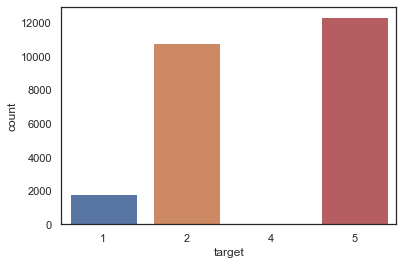

In [479]:
sns.countplot(data=submission, x='target')

In [430]:
# submission.to_csv('./Data/submission4.csv', index=False)